In [53]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv("train.csv")

def dfcleaner(dataframe):
    dataframe["Cabin"] = dataframe["Cabin"].fillna("0/999999/0")
    dataframe = dataframe.fillna(0)
    
    dataframe["Cabinnumber"] = dataframe["Cabin"].str.extract("\/(\w*)\/").astype("int32")
    dataframe["Cabindeck"] = dataframe["Cabin"].str.extract("^(\w*)\/")
    dataframe["Cabinside"] = dataframe["Cabin"].str.extract("\/(\w*)$")

    dataframe["Totalbill"] = dataframe["RoomService"] + dataframe["FoodCourt"] + dataframe["ShoppingMall"] + dataframe["Spa"] + dataframe["VRDeck"]

    dataframe["Group"] = dataframe["PassengerId"].str.extract("^(\d{4})")
    filter = dataframe["Group"].value_counts().to_frame().reset_index()
    filter.columns = ["Group", "Freq"]
    filter = filter[filter["Freq"] < 5]
    dataframe.loc[dataframe["Group"].isin(filter["Group"]), "Group"] = 0

    dataframe = pd.get_dummies(dataframe, columns = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Cabindeck", "Cabinside", "Group"], drop_first = True)
    #dataframe = pd.get_dummies(dataframe, columns = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Cabindeck", "Cabinside"], drop_first = True)
    
    
    dataframe.loc[dataframe["Cabinnumber"] == 999999, "Cabinnumber"] = 0

    return dataframe

In [55]:
df = dfcleaner(df)

In [56]:
df = df.select_dtypes(exclude = ["object"])

In [57]:
df.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabinnumber,Totalbill,HomePlanet_Earth,...,Group_8862,Group_8956,Group_8961,Group_8988,Group_9034,Group_9069,Group_9074,Group_9081,Group_9157,Group_9227
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,0,736.0,1,...,0,0,0,0,0,0,0,0,0,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,10383.0,0,...,0,0,0,0,0,0,0,0,0,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,5176.0,0,...,0,0,0,0,0,0,0,0,0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,1091.0,1,...,0,0,0,0,0,0,0,0,0,0


In [58]:
X, y = df.drop(["Transported"], axis = 1).values, df["Transported"].values
y = (y * 1).astype(np.int8)

In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.60, random_state = 42)

X_train.shape, X_test.shape

((6085, 154), (2608, 154))

In [60]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
#scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [61]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV

param_grid = dict(
    #n_estimators = list(range(180, 220, 10)),
    n_estimators = [180],
    #criterion = ["gini", "entropy", "log_loss"],
    criterion = ["log_loss"],
    min_samples_split = [2, 4, 8, 16, 24, 32],
    #max_features = ["sqrt", "log2", None, 5, 10],
    max_features = [10],
)

#classifier = GridSearchCV(
#    estimator = RandomForestClassifier(random_state = 42, n_jobs = -1),
#    param_grid = param_grid,
#    verbose = 3
#)

classifier = HalvingGridSearchCV(
    estimator = RandomForestClassifier(random_state = 42, n_jobs = -1),
    param_grid = param_grid,
    random_state = 42,
    verbose = 3
)

In [62]:
classifier = RandomForestClassifier(random_state = 42, n_jobs = -1)

In [63]:
classifier.fit(scaled_X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [45]:
classifier.best_estimator_

RandomForestClassifier(criterion='log_loss', max_features=10,
                       min_samples_split=4, n_estimators=180, n_jobs=-1,
                       random_state=42)

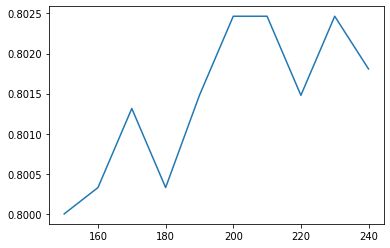

In [28]:

import matplotlib.pyplot as plt



plt.plot(list(classifier.cv_results_["param_n_estimators"]), classifier.cv_results_["mean_test_score"])

In [51]:
y_pred = classifier.predict(scaled_X_test)


              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1289
           1       0.82      0.77      0.80      1319

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608



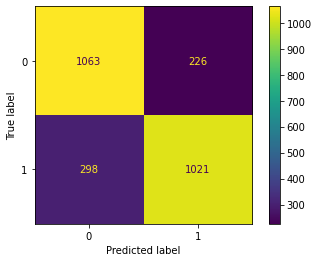

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [65]:
df_test = pd.read_csv("test.csv")
df_pid = df_test.loc[:, "PassengerId"]
df_test = dfcleaner(df_test)
df_test = df_test.select_dtypes(exclude = ["object"])
#df_test = df_test.drop(["PassengerId", "Cabin", "Name"], axis = 1)
df_test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabinnumber,Totalbill,HomePlanet_Earth,HomePlanet_Europa,...,Group_7893,Group_8361,Group_8543,Group_8793,Group_8800,Group_8804,Group_8925,Group_8980,Group_9016,Group_9238
0,27.0,0.0,0.0,0.0,0.0,0.0,3,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,19.0,0.0,9.0,0.0,2823.0,0.0,4,2832.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,31.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1,7418.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,20.0,10.0,0.0,635.0,0.0,0.0,5,645.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
str(tuple(["hej", "ho"]))

"('hej', 'ho')"

In [73]:
a = {"hej": 5, "hoe": 6}
a

{'hej': 5, 'hoe': 6}

In [76]:
tuple([(key, val) for key, val in a.items()])

(('hej', 5), ('hoe', 6))

In [ ]:
A, E, I, O, U, L, N, R, S, T       1
D, G                               2
B, C, M, P                         3
F, H, V, W, Y                      4
K                                  5
J, X                               8
Q, Z                               10

In [82]:
a = {key: 1 for key in "A, E, I, O, U, L, N, R, S, T".split(", ")}
a

{'A': 1,
 'E': 1,
 'I': 1,
 'O': 1,
 'U': 1,
 'L': 1,
 'N': 1,
 'R': 1,
 'S': 1,
 'T': 1}

In [88]:
a = dict(a, **{"D": 8, "G": 8})

In [92]:
def score(word):
    score_dict = {char: 1 for char in "A, E, I, O, U, L, N, R, S, T".split(", ")}
    score_dict = dict(score_dict, **{char: 2 for char in "D, G".split(", ")})
    score_dict = dict(score_dict, **{char: 3 for char in "B, C, M, P".split(", ")})
    score_dict = dict(score_dict, **{char: 4 for char in "F, H, V, W, Y".split(", ")})
    score_dict = dict(score_dict, **{"K": 5})
    score_dict = dict(score_dict, **{char: 8 for char in "J, X".split(", ")})
    score_dict = dict(score_dict, **{char: 10 for char in "Q, Z".split(", ")})

    return score_dict

score("f")

{'A': 1,
 'E': 1,
 'I': 1,
 'O': 1,
 'U': 1,
 'L': 1,
 'N': 1,
 'R': 1,
 'S': 1,
 'T': 1,
 'D': 2,
 'G': 2,
 'B': 3,
 'C': 3,
 'M': 3,
 'P': 3,
 'F': 4,
 'H': 4,
 'V': 4,
 'W': 4,
 'Y': 4,
 'K': 5,
 'J': 8,
 'X': 8,
 'Q': 10,
 'Z': 10}

In [79]:
"A, E, I, O, U, L, N, R, S, T".split(", ")

['A', 'E', 'I', 'O', 'U', 'L', 'N', 'R', 'S', 'T']

In [ ]:
['A', 'E', 'I', 'O', 'U', 'L', 'N', 'R', 'S', 'T']

In [95]:
scores = {}

for k, v in {
            "AEIOULNRST": 1,
            "DG": 2,
            "BCMP": 3,
            "FHVWY": 4,
            "K": 5,
            "JX": 8,
            "QZ": 10
        }.items():
    scores.update({x: v for x in k})

scores

{'A': 1,
 'E': 1,
 'I': 1,
 'O': 1,
 'U': 1,
 'L': 1,
 'N': 1,
 'R': 1,
 'S': 1,
 'T': 1,
 'D': 2,
 'G': 2,
 'B': 3,
 'C': 3,
 'M': 3,
 'P': 3,
 'F': 4,
 'H': 4,
 'V': 4,
 'W': 4,
 'Y': 4,
 'K': 5,
 'J': 8,
 'X': 8,
 'Q': 10,
 'Z': 10}

In [97]:
{"AEIOULNRST": 1, "DG": 2, "BCMP": 3, "FHVWY": 4, "K": 5, "JX": 8, "QZ": 10}

{'AEIOULNRST': 1, 'DG': 2, 'BCMP': 3, 'FHVWY': 4, 'K': 5, 'JX': 8, 'QZ': 10}

In [103]:
letter_table = '-AEIOULNRST-DG-BCMP-FHVWY-K---JX--QZ'.split('-')
for i,s in enumerate(letter_table): 
    for x in s:
        print(i, x)


1 A
1 E
1 I
1 O
1 U
1 L
1 N
1 R
1 S
1 T
2 D
2 G
3 B
3 C
3 M
3 P
4 F
4 H
4 V
4 W
4 Y
5 K
8 J
8 X
10 Q
10 Z


In [107]:
YACHT = 0
ONES = 1
TWOS = 2
THREES = 3
FOURS = 4
FIVES = 5
SIXES = 6
FULL_HOUSE = 7
FOUR_OF_A_KIND = 8
LITTLE_STRAIGHT = 9
BIG_STRAIGHT = 10
CHOICE = 11


def score(dice, category):
    if category < FULL_HOUSE:
        return sum([value for value in dice if value == category])
    if category == FULL_HOUSE and len(set(dice)) == 2:
        return sum(dice)
    if category == FOUR_OF_A_KIND:
        if dice.count(dice[0]) >= 4:
            return dice.count(dice[0]) * dice[0]
        if dice.count(dice[1]) >= 4:
            return dice.count(dice[1]) * dice[1]
    if category == LITTLE_STRAIGHT and len(set(dice)) == 5 and sum(dice) == 15:
        return 30
    if category == BIG_STRAIGHT and len(set(dice)) == 5 and sum(dice) == 20:
        return 30
    if category == YACHT and len(set(dice)) == 1:
        return 50
    if category == CHOICE:
        return sum(dice)

    return None


score([1, 1, 1, 2, 4], ONES)

3

In [108]:
digits([1, 2], 1)

NameError: name 'digits' is not defined

In [121]:
from random import randint

("kun", "fredrik", "daniel")[randint(0, 2)]

'daniel'